In [1]:
%load_ext watermark
%watermark

Last updated: 2021-04-25T19:04:24.126711+01:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 32 Stepping 1, AuthenticAMD
CPU cores   : 2
Architecture: 64bit



## Modelling

The aim of this notebook is to implement 2 different classification models, try them with different hyperparameters using a random search and finally choose the model that performs best on valdiation data to be tested against test data separated previously. The models will be:

- Random Forest
- Logistic Regression

In [98]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt

# Train set with no outliers
train_set_outliers = pd.read_pickle('./train_set.pkl')
X_train_outliers = train_set_outliers.drop(['Reached.on.Time_Y.N'], axis=1) 
y_train_outliers = train_set_outliers['Reached.on.Time_Y.N']

# Train set with outliers
train_set = pd.read_pickle('./train_set_outliers.pkl')
X_train = train_set.drop(['Reached.on.Time_Y.N'], axis=1)
y_train = train_set['Reached.on.Time_Y.N']

# Test set (20% of raw data)
test_set = pd.read_pickle('./test_set.pkl')
X_test = test_set.drop(['Reached.on.Time_Y.N'], axis=1)
y_test = test_set['Reached.on.Time_Y.N']

X_train.head(5)

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Price_paid
9169,1.0,0,0.777778,2.0,1,0,-0.833333,-0.918860,0,0,0,0,1,0,1,0,0.940126
2055,0.5,2,0.172840,0.0,2,0,5.166667,-0.158542,0,1,0,0,0,1,0,0,-0.494432
8761,-0.5,3,-0.962963,0.0,2,1,-0.166667,0.152936,0,0,0,0,1,0,1,0,-0.643511
8059,0.5,1,-0.283951,1.0,1,0,-0.666667,0.447905,0,0,0,0,1,0,1,0,-0.010255
5995,1.0,0,0.444444,1.0,1,1,-0.500000,-0.972434,0,0,0,0,1,0,0,1,0.593230


## Logistic Regression

In [3]:
# Training with data that doesn't contain any outliers
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# Distributions to randomize
distributions = dict(C=uniform(loc=0, scale=5),
                      penalty=['l2', 'l1'])

clf_logistic = RandomizedSearchCV(LogisticRegression(solver='saga', max_iter=1000), distributions, random_state=42)
search = clf_logistic.fit(X_train_outliers, y_train_outliers)
params = search.best_params_
params

{'C': 0.2904180608409973, 'penalty': 'l1'}

In [4]:
clf_lr = LogisticRegression(solver='saga', max_iter=1000, **params)
cv_results = cross_val_score(clf_lr, X_train_outliers, y_train_outliers, cv=10)
cv_results.mean()

0.5530590991929185

(array([[  16.,  112.,  213.,  661., 1625., 1997., 1412.,  540.,   92.,
            4.],
        [   4.,   92.,  540., 1412., 1997., 1625.,  661.,  213.,  112.,
           16.]]),
 array([0.19449275, 0.2555942 , 0.31669565, 0.3777971 , 0.43889855,
        0.5       , 0.56110145, 0.6222029 , 0.68330435, 0.7444058 ,
        0.80550725]),
 <a list of 2 BarContainer objects>)

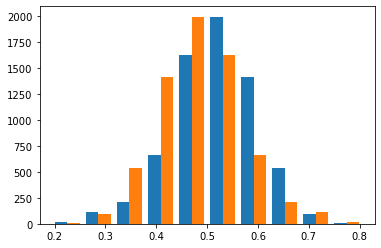

In [5]:
clf_lr.fit(X_train_outliers, y_train_outliers)
plt.hist(clf_lr.predict_proba(X_train_outliers))

In [6]:
# Training with data that contains all values
# Distributions to randomize
distributions = dict(C=uniform(loc=0, scale=5),
                      penalty=['l2'])
clf_logistic = RandomizedSearchCV(LogisticRegression(solver='saga', max_iter=1000), distributions, random_state=42)
search = clf_logistic.fit(X_train, y_train)
params = search.best_params_
params

{'C': 1.8727005942368125, 'penalty': 'l2'}

In [7]:
clf_lr_outliers = LogisticRegression(solver='saga', max_iter=1000, **params)
cv_results = cross_val_score(clf_lr_outliers, X_train, y_train, cv=10)
cv_results.mean()

0.6424588892336333

(array([[1733.,  276.,  253.,  938., 1848., 2096., 1363.,  287.,    5.,
            0.],
        [   0.,    5.,  287., 1363., 2096., 1848.,  938.,  253.,  276.,
         1733.]]),
 array([1.73363274e-04, 1.00138691e-01, 2.00104018e-01, 3.00069345e-01,
        4.00034673e-01, 5.00000000e-01, 5.99965327e-01, 6.99930655e-01,
        7.99895982e-01, 8.99861309e-01, 9.99826637e-01]),
 <a list of 2 BarContainer objects>)

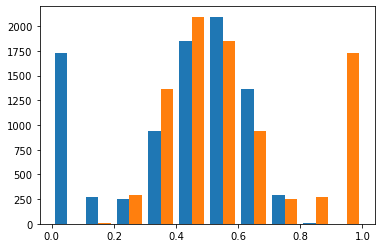

In [8]:
clf_lr_outliers.fit(X_train, y_train)
plt.hist(clf_lr_outliers.predict_proba(X_train))

## Random Forest

In [9]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

distributions = dict(max_features=['auto', 'sqrt', 'log2'], n_estimators=randint(80, 150), min_samples_split=randint(2, 20))

# Training with data that doesn't contain outliers
clf_rf = RandomizedSearchCV(RandomForestClassifier(), distributions, cv=10)
search = clf_rf.fit(X_train_outliers, y_train_outliers)
params = search.best_params_
params

{'max_features': 'log2', 'min_samples_split': 19, 'n_estimators': 134}

In [10]:
random_forest = RandomForestClassifier(**params)
cv_results = cross_val_score(random_forest, X_train_outliers, y_train_outliers, cv=10)
cv_results.mean()

0.5797392471428956

(array([[ 332.,  191.,  123.,  520., 1572., 1201., 2115.,  612.,    6.,
            0.],
        [   0.,    6.,  612., 2115., 1201., 1572.,  520.,  123.,  191.,
          332.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

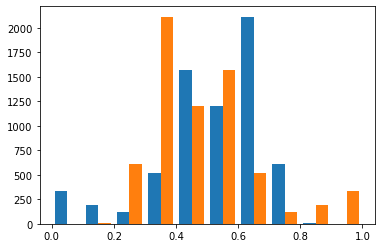

In [11]:
random_forest.fit(X_train_outliers, y_train_outliers)
plt.hist(random_forest.predict_proba(X_train_outliers))

In [82]:
# Training with data containing outliers
distributions = dict(criterion = ['gini','entropy'], max_features=['auto', 'sqrt', 'log2'], n_estimators=randint(80, 150), max_depth=randint(10,110),
                    min_samples_leaf=randint(2,10))
clf_rf = RandomizedSearchCV(RandomForestClassifier(), distributions, cv=10, scoring='accuracy')
search = clf_rf.fit(X_train, y_train)
params = search.best_params_
params

{'criterion': 'gini',
 'max_depth': 101,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'n_estimators': 136}

In [83]:
random_forest = RandomForestClassifier(**params)
cv_results = cross_val_score(random_forest, X_train, y_train, cv=10)
cv_results.mean()

0.6725771796462924

(array([[2301.,  184.,   90.,  491., 1624., 1411., 2143.,  551.,    4.,
            0.],
        [   0.,    4.,  551., 2143., 1411., 1624.,  491.,   90.,  184.,
         2301.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

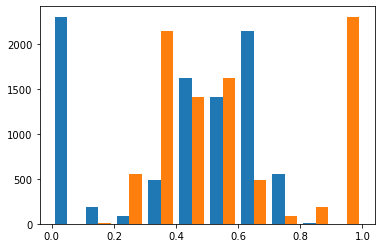

In [84]:
random_forest.fit(X_train, y_train)
plt.hist(random_forest.predict_proba(X_train))

## Evaluation

Random Forest with the dataset including outliers is the one that performs best on training data.

In [109]:
clf_test = RandomForestClassifier(**params, random_state=42)
clf_test.fit(X_train, y_train)

RandomForestClassifier(max_depth=101, max_features='sqrt', min_samples_leaf=6,
                       n_estimators=136, random_state=42)

In [110]:
scaler = RobustScaler()
numerical_columns = ['Customer_care_calls', 'Cost_of_the_Product','Discount_offered', 'Prior_purchases','Weight_in_gms', 'Price_paid']
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns])

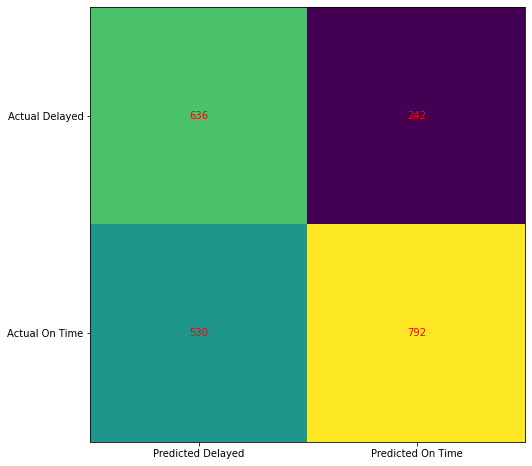

In [112]:
cm = confusion_matrix(y_test, rf_tuned.predict(X=X_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Delayed', 'Predicted On Time'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Delayed', 'Actual On Time'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

(array([[2270.,  207.,  114.,  473., 1643., 1403., 2135.,  551.,    3.,
            0.],
        [   0.,    3.,  551., 2135., 1403., 1643.,  473.,  114.,  207.,
         2270.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

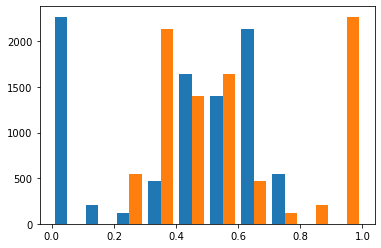

In [113]:
plt.hist(clf_test.predict_proba(X_train))

(array([[527.,  69.,  41.,  31., 253., 819., 439.,  21.,   0.,   0.],
        [  0.,   0.,  21., 439., 819., 253.,  31.,  41.,  69., 527.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

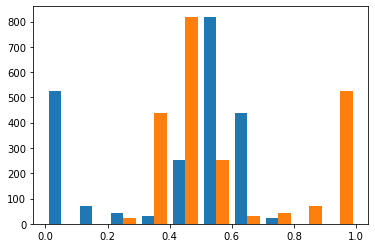

In [114]:
plt.hist(clf_test.predict_proba(X_test))

In [115]:
clf_test.score(X_test, y_test)

0.6568181818181819